In [1]:
import matplotlib.pyplot as plt
from t4gpd.io.CirReader import CirReader
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import geopandas
from math import *
from numpy.random import randint
from shapely.geometry import LineString,Point
from t4gpd.commons.GeomLib import GeomLib
from t4gpd.demos.GeoDataFrameDemos import GeoDataFrameDemos
from t4gpd.morph.geoProcesses.FootprintExtruder import FootprintExtruder
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
import random
from matplotlib.gridspec import GridSpec
import timeit

In [2]:
def SurfaceNormal(self): #input is the buildingsIn3d.geometry[i],than choose the polygon of one facet
    coord = self.exterior.coords
    facet_p0=np.array(coord[0])
    facet_p1=np.array(coord[1])
    facet_p2=np.array(coord[2])
    vec1 = facet_p1 - facet_p0
    vec2 = facet_p2 - facet_p1
    a = vec1[1]*vec2[2]-vec1[2]*vec2[1]
    b = vec1[2]*vec2[0]-vec1[0]*vec2[2]
    c = vec1[0]*vec2[1]-vec1[1]*vec2[0]
    normal = np.array([a,b,c])
    mod = module(normal)
    n  = normal/mod
    return n

In [3]:
def module(vector):
    return np.sqrt(np.dot(np.array(vector),np.array(vector)))

In [4]:
def centroid(self): #rectangle centroid
    coord = self.exterior.coords
    face_p0=np.array(coord[0])
    face_p2=np.array(coord[2])
    face_ce=(face_p0+face_p2)/2
    return Point(face_ce)

In [5]:
def distance3d(point1,point2):
    d = sqrt((point1.x-point2.x)**2 + (point1.y-point2.y)**2 + (point1.z-point2.z)**2)
    return d

In [6]:
def isa(face1,face2):#view factor from 1 to 2
    n1=SurfaceNormal(face1.geometry)
    n2=SurfaceNormal(face2.geometry)
    a2=area3d(face2.geometry)
    vec_R=np.array([face1.CentroidPoint.x-face2.CentroidPoint.x,face1.CentroidPoint.y-face2.CentroidPoint.y,face1.CentroidPoint.z-face2.CentroidPoint.z])
    vf=-a2*np.dot(n1,vec_R)*np.dot(n2,vec_R)/(pi*module(vec_R)**4)
    return vf

In [7]:
#grid surface3d into meshes of size n*m
def grid3d(self,n,m):#n rows, m columns
    coord = self.exterior.coords
    p0=np.array(coord[0])
    p1=np.array(coord[1])
    p2=np.array(coord[2])
    p3=np.array(coord[3])
    vec1 = (p1-p0)/m
    vec2 = (p2-p1)/n
    poly=[]
    cen_p=[]
    sur_d=[]
    for i in range(n):
        for j in range(m):
            p0_t=Point(p0+j*vec1+i*vec2)
            p1_t=Point(p0+(j+1)*vec1+i*vec2)
            p2_t=Point(p0+(j+1)*vec1+(i+1)*vec2)
            p3_t=Point(p0+j*vec1+(i+1)*vec2)
            face_t = Polygon([p0_t,p1_t,p2_t,p3_t,p0_t])
            poly.append(face_t)
            cen_p.append(centroid(face_t))
            sur_d.append(Surface_diameter(face_t))
    self_grid=GeoDataFrame({'geometry': poly},crs='epsg:2154')
    self_grid['CentroidPoint']=cen_p
    self_grid['diameter']=sur_d
    return self_grid

In [8]:
#get area from 3d polygon
def area3d(self):
    coord = self.exterior.coords
    d1 = distance3d(Point(coord[0]),Point(coord[1]))
    d2 = distance3d(Point(coord[1]),Point(coord[2]))
    return d1*d2

In [9]:
def Surface_diameter(surface):
    coord = surface.exterior.coords
    d = distance3d(Point(coord[0]),Point(coord[2]))
    return d

In [10]:
def ParallelVF(a,b):#a=width/distance,b=height/distance
    f = 2/(pi*a*b)*(log(((1+a**2)*(1+b**2)/(1+a**2+b**2))**0.5)+
                    (a*(1+b**2)**0.5)*atan(a/(1+b**2)**0.5)+
                    (b*(1+a**2)**0.5)*atan(b/(1+a**2)**0.5)-
                    a*atan(a)-
                    b*atan(b))
    return f

In [11]:
def VerticalVF(a,b):#a = h/w , b = l/w
    f = 1/(pi*b)*(b*atan(1/b)+a*atan(1/a)-((a**2+b**2)**0.5)*atan(1/((a**2+a**2)**0.5))+0.25*log((1+b**2)*(1+a**2)/(1+b**2+a**2)*((b**2*(1+b**2+a**2)/((1+b**2)*(b**2+a**2)))**(b**2))*(a**2*(1+a**2+b**2)/((1+a**2)*(a**2+b**2)))**(a**2)))
    return f

In [12]:
def CreateFaces(x,y,method): #x=w/d, y=h/d
    k = y/x
    polygon1 = []
    polygon2 = []
    coords_3d_1 = np.array([[10,0,0], [0,0,0], [0,0,10*k], [10,0,10*k], [10,0,0]])
    if method == 'parallel':
        coords_3d_2 = np.array([[0,10/x,0], [10,10/x,0], [10,10/x,10*k], [0,10/x,10*k], [0,10/x,0]])
    elif method == 'vertical':
        coords_3d_2 = np.array([[0,0,0], [10,0,0], [10,10/x,0], [0,10/x,0], [0,0,0]])
    else:
        return 'Please select your method "parallel" or "vertical"?'
    polygon1.append(Polygon(coords_3d_1))
    polygon2.append(Polygon(coords_3d_2))
    f1 = GeoDataFrame({'geometry':polygon1},crs='epsg:2154')
    f2 = GeoDataFrame({'geometry':polygon2},crs='epsg:2154')
    
    f1['area'] = area3d(f1.geometry.iloc[0])
    f2['area'] = area3d(f2.geometry.iloc[0])
    
    f1['diameter'] = Surface_diameter(f1.geometry.iloc[0])
    f2['diameter'] = Surface_diameter(f2.geometry.iloc[0])
    
    f1['CentroidPoint'] = centroid(f1.geometry.iloc[0])
    f2['CentroidPoint'] = centroid(f2.geometry.iloc[0])
    return f1,f2

In [13]:
def isFiveTimeRuleOk(f1,f2):
    return distance3d(f1.CentroidPoint,f2.CentroidPoint) >= 5*f1.diameter

# Parallel faces
Subdivide source surface

In [14]:
#Subdivide function 2
def Subdivide2(f1,f2): #f1 is the emitting surface, f2 is the target surface
    if isFiveTimeRuleOk(f1,f2):
        return [f1]
    else:
        d = distance3d(f1.CentroidPoint,f2.CentroidPoint)/5
        coord1 = f1.geometry.exterior.coords
        w1 = distance3d(Point(coord1[0]),Point(coord1[1]))
        h1 = distance3d(Point(coord1[1]),Point(coord1[2]))
        
        n1 = int(h1/d)+1
        m1 = int(w1/d)+1
        
        return grid3d(f1.geometry,n1,m1)

In [15]:
L1 = [1.4,1.2,1,0.8,0.6,0.4,0.2]
error1 = []
time1 = []
vf1 = []
vf_a = []
for j in range(len(L1)):
    start = timeit.default_timer()
    f1,f2 = CreateFaces(L1[j],L1[j],'parallel')
    d = GeoDataFrame(Subdivide2(f1.iloc[0],f2.iloc[0]))
    #c = GeoDataFrame(Subdivide2(f2.iloc[0],f1.iloc[0]))
    vftest = 0
    for i in range(len(d)):
        face_0 = d.iloc[i]
        vf1_isa = isa(face_0,f2.iloc[0])
        vftest = vftest + vf1_isa/len(d)
    vf1.append(vftest)
    vf_a.append(ParallelVF(L1[j],L1[j]))
    stop = timeit.default_timer()
    error1.append((vftest-ParallelVF(L1[j],L1[j]))/ParallelVF(L1[j],L1[j])*100)
    time1.append(stop-start)

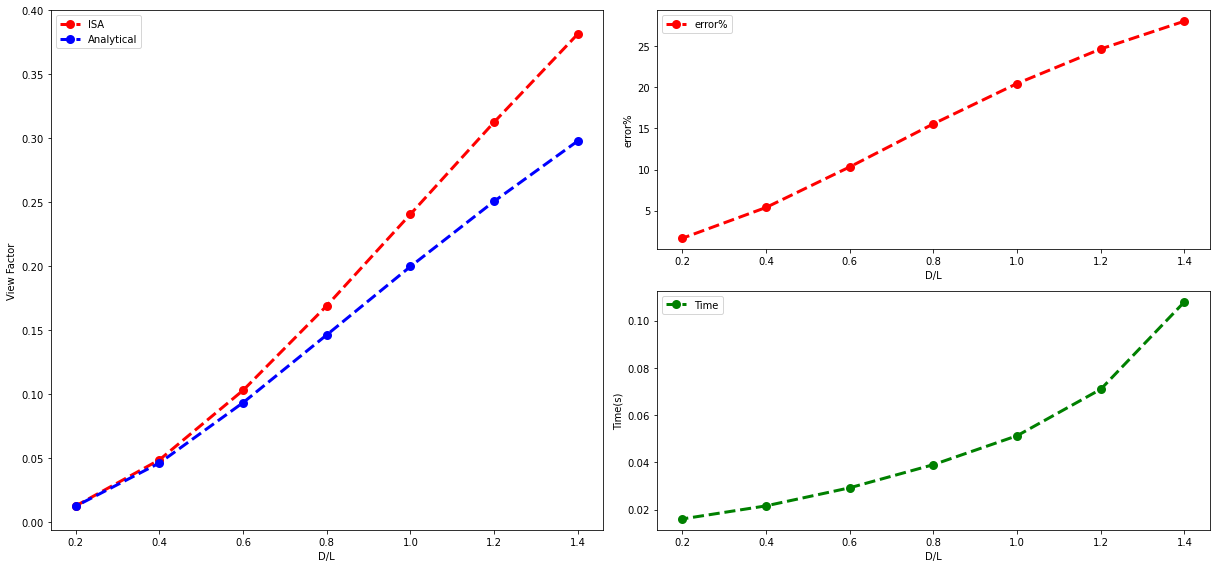

In [16]:
fig = plt.figure(figsize=(17,8))
gs = GridSpec(nrows=2,ncols=2)

ax0 = fig.add_subplot(gs[:,0])
ax0.plot(L1,vf1,'r--',label = 'ISA',linewidth=3,marker='o',markeredgewidth=3)
ax0.plot(L1,vf_a,'b--',label = 'Analytical',linewidth=3,marker='o',markeredgewidth=3)
ax0.set(xlabel='D/L',ylabel='View Factor')
plt.legend()

ax1 = fig.add_subplot(gs[0,1])
ax1.plot(L1,error1,'r--',label = 'error%',linewidth=3,marker='o',markeredgewidth=3)
ax1.set(xlabel='D/L',ylabel='error%')
plt.legend()

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(L1,time1,'g--',label = 'Time',linewidth=3,marker='o',markeredgewidth=3)
ax2.set(xlabel='D/L',ylabel='Time(s)')
plt.legend()
plt.tight_layout()
plt.savefig('C:/Users/zcui/Desktop/fig/Subdivide1.png',dpi=500)

Subdivide both source surface and target surface

In [17]:
L2 = [1.4,1.2,1,0.8,0.6,0.4,0.2]
error2 = []
time2 = []
vf2 = []
vf_a = []
for j in range(len(L2)):
    start = timeit.default_timer()
    f1,f2 = CreateFaces(L2[j],L2[j],'parallel')
    d = GeoDataFrame(Subdivide2(f1.iloc[0],f2.iloc[0]))
    c = GeoDataFrame(Subdivide2(f2.iloc[0],f1.iloc[0]))
    vftest = 0
    for i in range(len(d)):
        face_0 = d.iloc[i]
        vf2_isa = [isa(face_0,face_1) for face_1 in c.iloc]
        vftest = vftest + sum(vf2_isa)/len(d)
    vf2.append(vftest)
    vf_a.append(ParallelVF(L2[j],L2[j]))
    stop = timeit.default_timer()
    error2.append((vftest-ParallelVF(L2[j],L2[j]))/ParallelVF(L2[j],L2[j])*100)
    time2.append(stop-start)

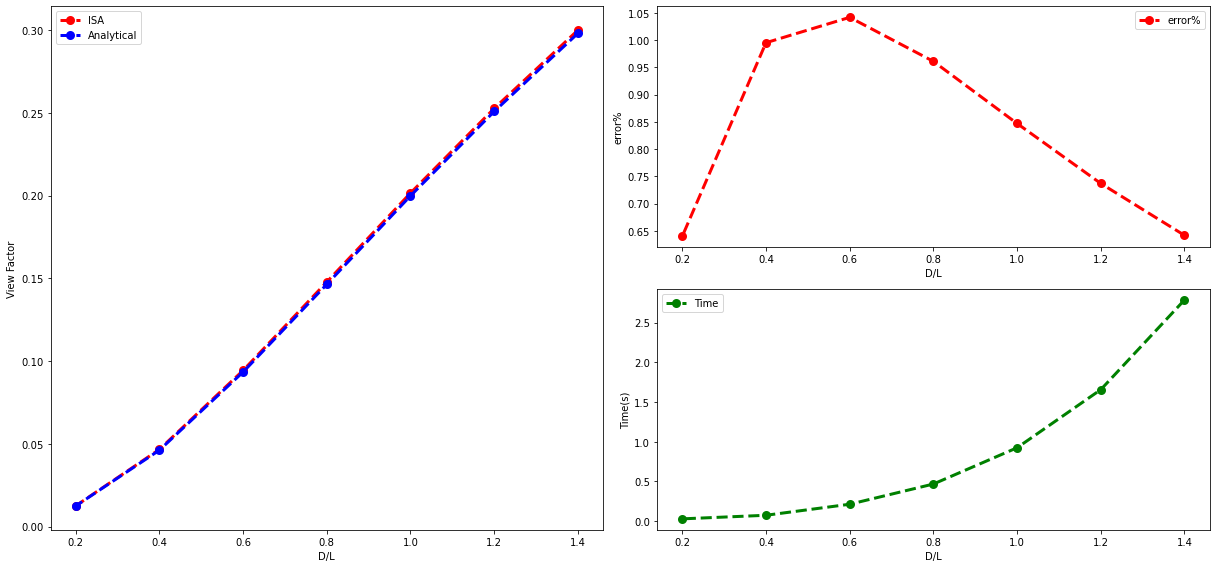

In [18]:
fig = plt.figure(figsize=(17,8))
gs = GridSpec(nrows=2,ncols=2)

ax0 = fig.add_subplot(gs[:,0])
ax0.plot(L2,vf2,'r--',label = 'ISA',linewidth=3,marker='o',markeredgewidth=3)
ax0.plot(L2,vf_a,'b--',label = 'Analytical',linewidth=3,marker='o',markeredgewidth=3)
ax0.set(xlabel='D/L',ylabel='View Factor')
plt.legend()

ax1 = fig.add_subplot(gs[0,1])
ax1.plot(L2,error2,'r--',label = 'error%',linewidth=3,marker='o',markeredgewidth=3)
ax1.set(xlabel='D/L',ylabel='error%')
plt.legend()

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(L2,time2,'g--',label = 'Time',linewidth=3,marker='o',markeredgewidth=3)
ax2.set(xlabel='D/L',ylabel='Time(s)')
plt.legend()
plt.tight_layout()
plt.savefig('C:/Users/zcui/Desktop/fig/Subdivide2.png',dpi=500)

# Vertical Condition
devide horizontal faces into grids

In [19]:
#Subdivide function
def Subdivide(f1,f2): #f1 is the emitting surface, f2 is the target surface
    if isFiveTimeRuleOk(f1,f2):
        return [f1]
    else:
        result = []
        f_grid = grid3d(f1.geometry,2,2)
        for i in range(len(f_grid)):
            if isFiveTimeRuleOk(f_grid.iloc[i],f2):
                result.append(f_grid.iloc[i])
            else:
                result += Subdivide(f_grid.iloc[i],f2)
        return result

In [20]:
f3,f4 = CreateFaces(1,1,'vertical')
L3 = [2,3,4,5,6,7,8]
viewfactor = []
error3=[]
time3=[]
vf_a_v=[]
for i in L3:
    start = timeit.default_timer()
    grid = grid3d(f4.geometry.squeeze(),i,i)
    vf = []
    for j in range(len(grid)):
        f4_grid = grid.iloc[j]
        list_sub = Subdivide(f3.iloc[0],f4_grid)
        testgeo = GeoDataFrame(list_sub)
        area = [area3d(item) for item in testgeo.geometry]
        testgeo['area']=area
        vf_isa = [isa(tg,f4_grid)*tg.area/100 for tg in testgeo.iloc]
        vf.append(sum(vf_isa))
    viewfactor.append(sum(vf))
    vf_a_v.append(VerticalVF(1,1))
    error3.append(abs(VerticalVF(1,1)-sum(vf))/VerticalVF(1,1)*100)
    stop = timeit.default_timer()
    time3.append(stop-start)

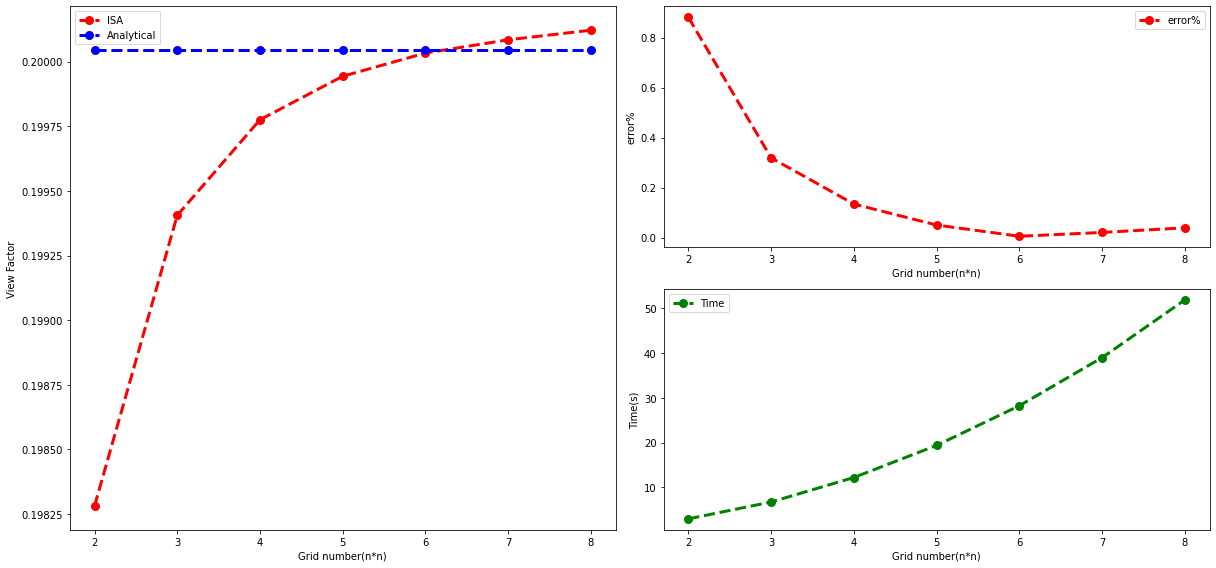

In [21]:
fig = plt.figure(figsize=(17,8))
gs = GridSpec(nrows=2,ncols=2)

ax0 = fig.add_subplot(gs[:,0])
ax0.plot(L3,viewfactor,'r--',label = 'ISA',linewidth=3,marker='o',markeredgewidth=3)
ax0.plot(L3,vf_a_v,'b--',label = 'Analytical',linewidth=3,marker='o',markeredgewidth=3)
ax0.set(xlabel='Grid number(n*n)',ylabel='View Factor')
plt.legend()

ax1 = fig.add_subplot(gs[0,1])
ax1.plot(L3,error3,'r--',label = 'error%',linewidth=3,marker='o',markeredgewidth=3)
ax1.set(xlabel='Grid number(n*n)',ylabel='error%')
plt.legend()

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(L3,time3,'g--',label = 'Time',linewidth=3,marker='o',markeredgewidth=3)
ax2.set(xlabel='Grid number(n*n)',ylabel='Time(s)')
plt.legend()
plt.tight_layout()
plt.savefig('C:/Users/zcui/Desktop/fig/Subdivide3.png',dpi=500)